### Description: This dataset includes real-time and historical traffic congestion data from Chicago, including  ### traffic flow, speed, and incident reports. It's valuable for studying traffic patterns in urban environments.

## Dataset Overview

#### 1. `ID`: A unique identifier for each traffic count record.

#### 2. `Traffic Volume Count Location Address`: The address where the traffic volume was recorded.

#### 3. `Street`: The street name where the traffic count was taken.

#### 4. `Date of Count`: The date on which the traffic count was recorded.

#### 5. `Total Passing Vehicle Volume`: The total number of vehicles that passed the location during the count period.

#### 6. ` Vehicle Volume By Each Direction of Traffic`: The vehicle count divided by direction (e.g., East Bound, West Bound).

#### 7. `Latitude`: The latitude coordinate of the traffic count location.

#### 8. `Longitude`: The longitude coordinate of the traffic count location.

#### 9. `Location`: The geographic location as a tuple of latitude and longitude.

Check out the [City of Chicago Traffic Data](https://www.chicago.gov/city/en/depts/cdot/dataset/average_daily_trafficcounts.html) for more information.


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/main/notebook.ipynb)

## Import Necessary Libraries.

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

## Load The Data.

In [18]:
df_traffic = pd.read_csv("../DataSet/Average_Daily_Traffic_Counts_-_2006.csv")

## Shape Of The Data.

In [19]:
df_traffic.shape

(1279, 9)

## Head values.

In [20]:
df_traffic.head().T

,0,1,2,3,4
ID,414,176,1367,316,1294
Traffic Volume Count Location Address,5838 West,320 East,1730 East,125 East,2924 East
Street,Lake St,76th St,57th Dr,24th St,130th St
Date of Count,11/14/2006,03/28/2006,08/24/2006,03/30/2006,08/29/2006
Total Passing Vehicle Volume,7100,8600,53500,700,4200
Vehicle Volume By Each Direction of Traffic,East Bound: 3600 / West Bound: 3500,East Bound: 3800 / West Bound: 4800,East Bound: 27800 / West Bound: 25700,East Bound: 400 / West Bound: 300,East Bound: 2300 / West Bound: 1900
Latitude,41.887904,41.756542,41.792663,41.849302,41.659177
Longitude,-87.771064,-87.617335,-87.582231,-87.622658,-87.552112
Location,"(41.887904, -87.771064)","(41.756542, -87.617335)","(41.792663, -87.582231)","(41.849302, -87.622658)","(41.659177, -87.552112)"


## Summary statistics of the numerical attributes.

In [21]:
df_traffic.describe()

,ID,Total Passing Vehicle Volume,Latitude,Longitude
count,1279.000000,1279.000000,1279.000000,1279.000000
mean,689.937451,19466.301798,41.849394,-87.670298
std,395.568121,12448.378467,0.083917,0.060891
min,1.000000,700.000000,41.651861,-87.854842
25%,348.500000,11350.000000,41.780249,-87.710013
50%,684.000000,17300.000000,41.871380,-87.662850
75%,1028.500000,24200.000000,41.909196,-87.628631
max,1382.000000,165200.000000,42.017888,-87.529702


## Summary statistics of the categorical attributes.

In [22]:
df_traffic.describe(include='O')

,Traffic Volume Count Location Address,Street,Date of Count,Vehicle Volume By Each Direction of Traffic,Location
count,1279,1279,1279,1279,1279
unique,1203,251,95,1223,1276
top,210 South,Damen Ave,03/28/2006,North Bound: 6300 / South Bound: 6200,"(41.828474, -87.65091)"
freq,4,33,73,4,2


## Information about the dataset.

In [23]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ID                                           1279 non-null   int64  
 1   Traffic Volume Count Location  Address       1279 non-null   object 
 2   Street                                       1279 non-null   object 
 3   Date of Count                                1279 non-null   object 
 4   Total Passing Vehicle Volume                 1279 non-null   int64  
 5   Vehicle Volume By Each Direction of Traffic  1279 non-null   object 
 6   Latitude                                     1279 non-null   float64
 7   Longitude                                    1279 non-null   float64
 8   Location                                     1279 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 90.1+ KB


## Data visualization.

### Data visualization for the Latitude and Longitude.

In [24]:
fig = px.scatter_mapbox(df_traffic, lat="Latitude", lon="Longitude", color="Total Passing Vehicle Volume",
                            hover_name="Date of Count", hover_data=["Total Passing Vehicle Volume"],
                            color_continuous_scale=px.colors.cyclical.IceFire, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

<Axes: xlabel='Longitude', ylabel='Latitude'>

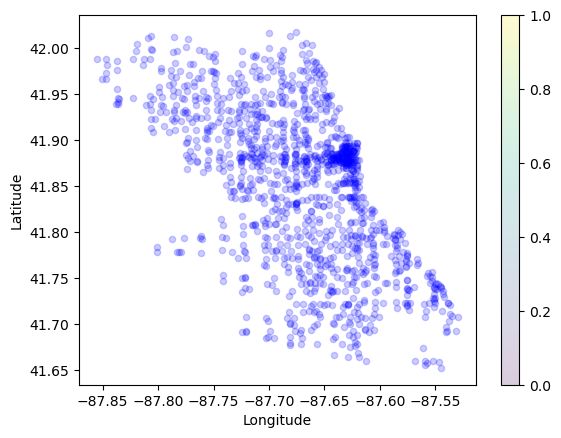

In [25]:
df_traffic.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.2,c='blue', colorbar=True)

## Top 10 Streets with traffic jams.

<Axes: title={'center': 'Top 10 Streets with traffic jams.'}, xlabel='Street'>

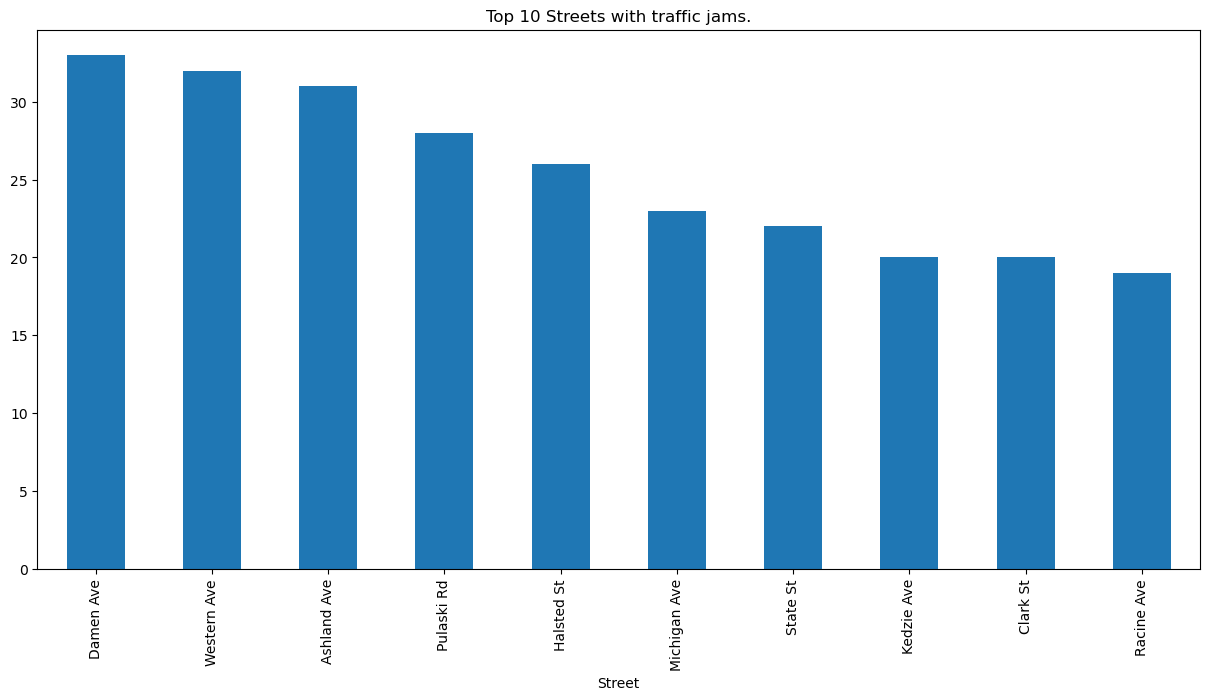

In [26]:
df_traffic['Street'].value_counts().head(10).plot(kind='bar', figsize=(15, 7), title='Top 10 Streets with traffic jams.')

## Data Preprocessing.

In [29]:
df_traffic.drop(columns=['ID ', 'Location'], axis=1, inplace=True)